# Project and classify a new query study onto an integrated reference atlas (no sharing)

- In this notebook we will demnsotrate how you can build a reference atlas and then project 
a new query stuy on the top of your reference atlas

- We provide a cell type classifier if you have cell type labels for the reference data to transfer labels from
reference to query study

In [2]:
import os
os.chdir("/home/mohsen/projects/scnet/")

In [3]:
import scarches as sca
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')

Using TensorFlow backend.


`condition_key` is the column name which stores batch id in your `adata.obs`

In [4]:
condition_key = "study"

## Loading data

In [5]:
adata = sca.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### We hold out one of our studies to be used as query study later 

In [8]:
target_conditions = ["Pancreas SS2"]

reference_adata

In [9]:
reference_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
reference_adata

View of AnnData object with n_obs × n_vars = 12720 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
query_adata = adata[adata.obs[condition_key].isin(target_conditions)]
query_adata

View of AnnData object with n_obs × n_vars = 2961 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [11]:
reference_batch_labels = reference_adata.obs[condition_key].unique().tolist()

## Create an instance of scArches model for reference integration

In [12]:
network = sca.models.scArches(task_name='pancreas_reference',
                              x_dimension=adata.shape[1], 
                              z_dimension=10,
                              architecture=[128, 128],
                              gene_names=adata.var_names.tolist(),
                              conditions=reference_batch_labels,
                              alpha=0.001,
                              use_batchnorm=False,
                              loss_fn='sse',
                              model_path="./models/scArches/",
                              )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


## Train scArches

You can train scArches with `train` function with the following parameters:

1. __adata__: Annotated dataset used for training and evaluating scArches.
2. __condition_key__: name of the column in `obs` matrix in `adata` which contains the batch_id for each sample.
3. __n_epochs__: number of epochs used to train scArches.
4. __batch_size__: number of sample used to sample as mini-batches in order to optimize scArches. Please __NOTE__ that for MSE loss with MMD regularization batch sizes upper that 512 is highly recommended 
8. __save__: whether to save scArches' model and configs after training phase or not. 
9. __retrain__: if `False` and scArches' pretrained model exists in `model_path`, will restore scArches' weights. Otherwise will train and validate scArches on `adata`. 

In [14]:
network.train(reference_adata,
              n_epochs=100,
              condition_key=condition_key,
              batch_size=128)

Instructions for updating:
Use tf.cast instead.
 |████████████████████| 100.0%  - loss: 958.3064 - mmd_loss: 0.0000 - reconstruction_loss: 958.3064 - val_loss: 937.0049 - val_mmd_loss: 0.0000 - val_reconstruction_loss: 937.004986

scArches has been successfully saved in ./models/scArches/pancreas_reference.


## Get latent output for the reference dataset

Latent space representation of reference data can be computed using `get_latent` function
This function has the following parameters:

1. __adata__: Annotated dataset to be transformed to latent space
2. __condition_key__: Name of the column in `obs` matrix in `adata` which contains the study for each sample.


In [15]:
latent_adata = network.get_latent(reference_adata, condition_key, return_z=True)
latent_adata

AnnData object with n_obs × n_vars = 12720 × 10 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## UMAP visualization of reference latent with Scanpy

In [16]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

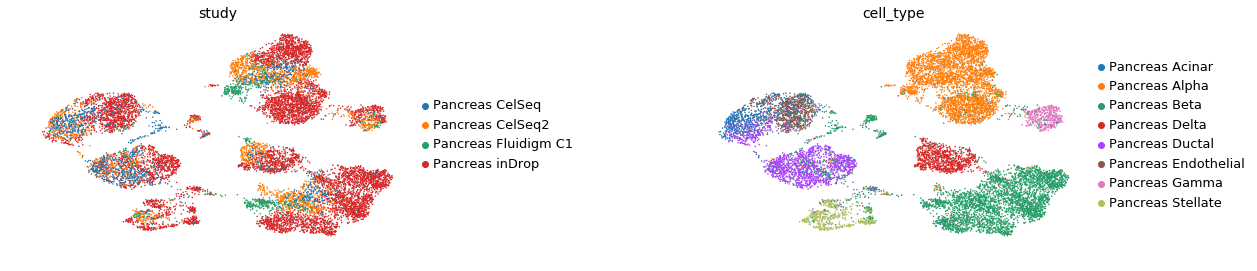

In [17]:
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           frameon=False, wspace=0.6)

## projecting query data on the top of reference data 
In order to perform Architecture surgery on pre-trained scArches model, `operate` function is available with the following arguments:

1. __network__: pre-trained scArches object.
2. __new_task_name__: name of the task you want to solve (related to query atlas you have)
3. __new_conditions__: list of (unique) new studies.

In [29]:
new_network = sca.operate(network,
                          new_task_name="pancreas_query",
                          new_conditions=target_conditions)

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


## Train with query dataset

In [30]:
new_network.train(query_adata,
                  condition_key=condition_key,
                  batch_size=128,
                  n_epochs=50)

 |████████████████████| 100.0%  - loss: 1032.5755 - mmd_loss: 0.0000 - reconstruction_loss: 1032.5755 - val_loss: 1032.2392 - val_mmd_loss: 0.0000 - val_reconstruction_loss: 1032.2392

scArches has been successfully saved in ./models/scArches/pancreas_query.


## Project query+reference data in to the latent space

In [50]:
latent_adata = new_network.get_latent(adata, condition_key, return_z=True)

- Note that `latent_adata` contains integrated latent representation for both query and reference data, this adata can be used
for down-stream analysis such as clustering, explatory analysis, differential test and etc

In [51]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

##### as you can see `Pancrease SS2` is added to the reference data

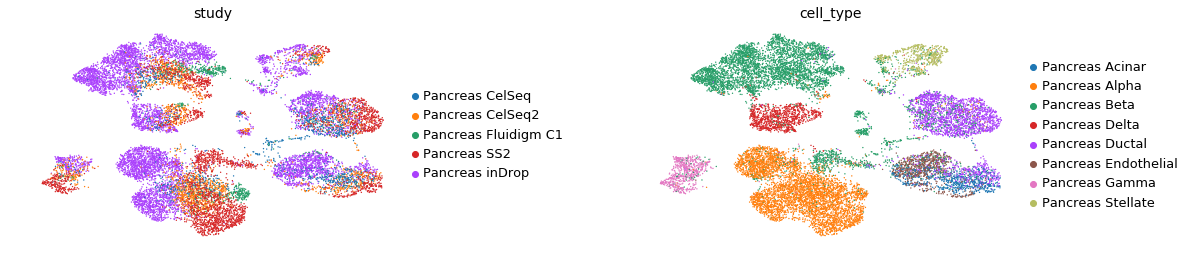

In [52]:
sc.pl.umap(latent_adata, color=[condition_key, "cell_type"], 
           wspace=0.5, frameon=False)

# transferring  cell type labels from reference to query data

In order to annotate cell types in the query data (`query_adata`), you can use `scArches.ann.weighted_knn` function. There are a few arguments explained below.

1. __n_neighbors__: Number of nearest neighbors used to train the weighted KNN classifier.
2. __threshold__: uncertainty threshold to be used to label cells with high uncertainty as 'Unknown'. cells with `uncertainty` > `threshold` will be labeled as unknown.
3. __label_key__: column containing cell-type labels in `adata.obs`.

In [45]:
n_neighbors = 5
threhsold = 0.5

### Project query and reference data in the latent space

In [46]:
train_latent = new_network.get_latent(reference_adata, condition_key)
valid_latent = new_network.get_latent(query_adata, condition_key)

#####  __Note__ : predicted labels will be stored at `evaluation` col in your `valid.obs`

In [47]:
sca.ann.weighted_knn(train_latent, 
                     valid_latent,
                     label_key="cell_type",
                     n_neighbors=n_neighbors,
                     threshold=threhsold,
                     )

Weighted KNN with n_neighbors = 5 and threshold = 0.5 ... finished!
Number of correctly classified samples: 2450
Number of misclassified samples: 457
Number of samples classified as unknown: 54


## UMAP visualization of correct/incorrect/unknown cells

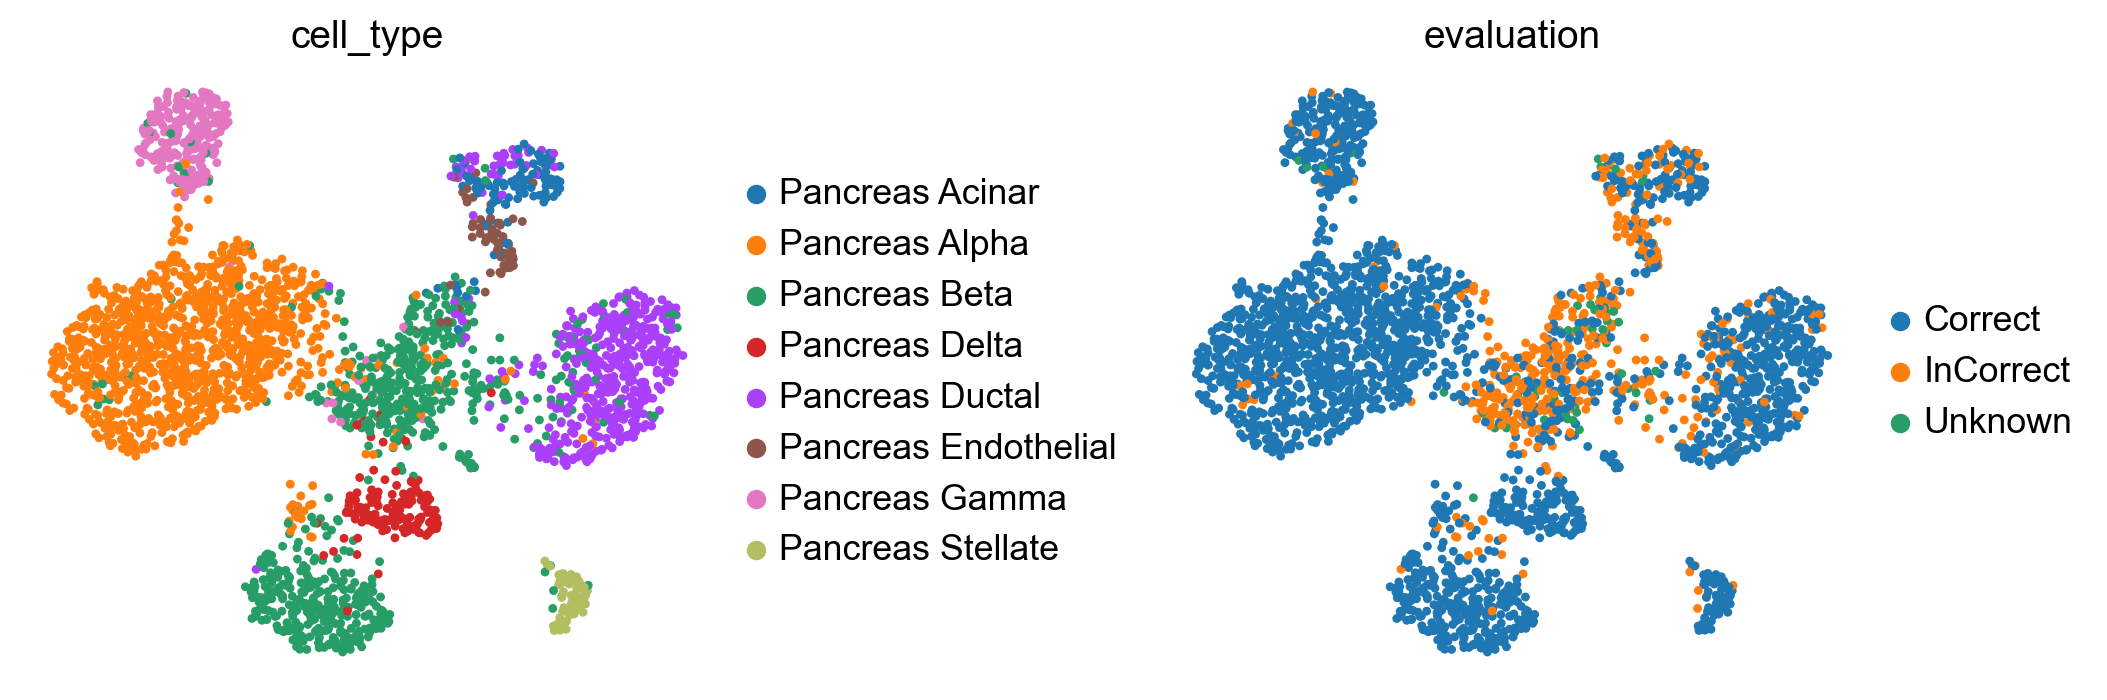

In [50]:
sc.pp.neighbors(valid_latent)
sc.tl.umap(valid_latent)
sc.pl.umap(valid_latent, color=["cell_type", 'evaluation'], wspace=0.5, frameon=False)

## Uncertainty UMAP visualization 

__Hint__ : higher the uncentainty shows the classifer was not confident about the predicted labels in that region

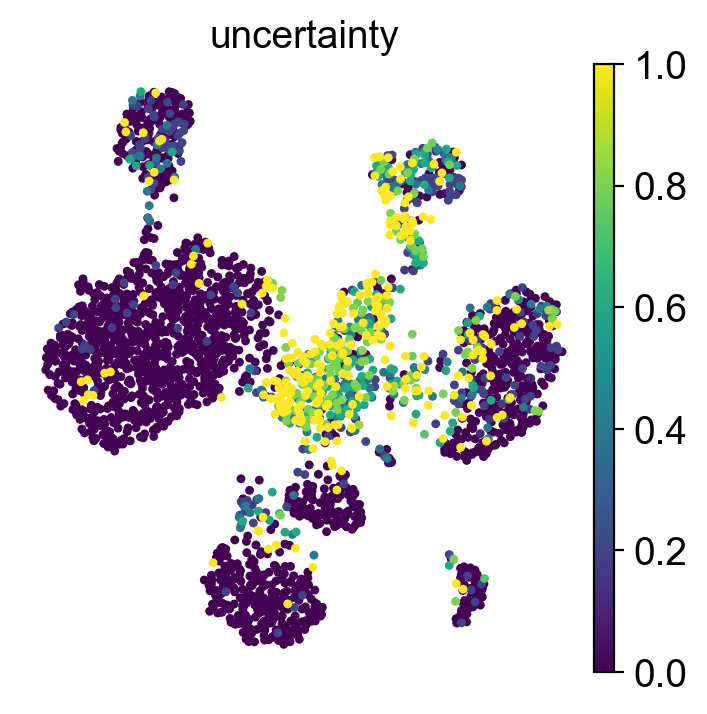

In [52]:
sc.pl.umap(valid_latent, color='uncertainty', frameon=False)